---

# PyTorchを使用した機械学習
機械学習で使用されるライブラリの中で有名なものの中にPyTorchがあります．  
以降では，PyTorchを使用した機械学習の方法を説明していきます．

勾配効果法による学習の流れは，下記の通りです．

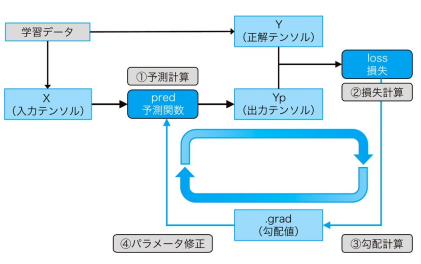



---


## ①予測計算
機械学習モデルは上図の「予測関数」predと書かれている部分に当たります．   
ここで，**入力テンソルX**を入力とし，予測結果は**出力テンソルYp**に出力されるものとします．  

この例では，予測関数は下記の様な一次関数となります．    
$$  \mathrm{Y_p = W*X+B} $$  
このように，予測関数によりYpを求めることを「①予測計算」と呼びます．  
予測関数は係数Wと定数Bをパラメータに持っているので，このパラメータが変わると，「予測計算」の結果も変わります（Wは重み，Bはバイアスと呼ばれます）．



---

## ②損失計算
「教師あり学習」において学習データは，入力と正解値の両方を含むので，正解値の例を分離して**正解テンソルY**とします．  

予測結果のYpと正解のYは異なっているのが普通なので，その違いの程度を評価する目的で，この2つのテンソルを入力とする**損失Loss**を定義します．  

機械学習の目標は，損失が小さくなるようなパラメータB,Wを求めることですが，これは「②損失計算」に当たります．  

損失関数は問題設定によって適したものを採用します．



---

## ③勾配計算
予測関数を構成するパラメータを少しずつ変えながらその時の損失の変化の度合い（勾配）を調べます．



---

## ④パラメータ修正
勾配値に小さな定数（**学習率**）lrをかけ，その値だけWとBを同時にずらします．これを**パラメータ修正**といいます．

---

このように①〜④を繰り返すことで，学習が進んでいきます．

## 勾配降下法の実装

さて，それでは勾配降下法の実装を行っていきましょう．  
ここでは，機械学習の中で最も単純な問題である線形回帰について解いていきましょう．

問題設定は以下のようにします．

---

5人の人間が下記のような（身長，体重）の場合を考える  
(166, 58.7), (176, 75.7), (171, 62.1), (173, 70.4), (169, 60.1)  

身長をx軸，体重を縦軸とすると下記のようなグラフになる
  
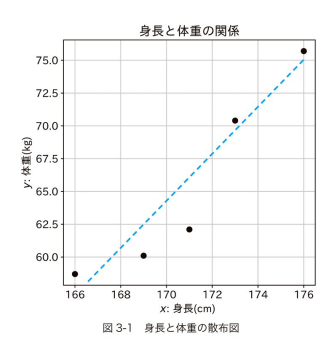 

---

上記のグラフをみると，身長の体重の間には何かしらの関係があるような気がします．
  
ここで，線形回帰の目的を今回の問題に当てはめると
- 5つの点に最も合った1次関数を求める（上図の点線にあたる）

ということになります．

### ⓪データ前処理
最初に学習に必要なデータを用意しましょう．  
上記で示した5組（身長，体重）のデータを学習データにします

In [ ]:
import numpy as np

# 学習データの用意
sampleData = np.array([
    [166, 58.7], 
    [176.0, 75.7],
    [171.0, 62.1],
    [173.0, 70.4],
    [169.0, 60.1]
])

# 学習データを入力データx，正解データyに分割
x = sampleData[:, 0]
y = sampleData[:, 1]


<br>

次にデータの変換を行います．  
一般に，勾配降下法では
- 対象となる数値が1以内に収まるような比較的小さな値の方が望ましい

ことが分かっています．今回の場合，身長も体重も大きな数値なので，それぞれの平均値を引きことで勾配降下法がやりやすい条件に変更することにします．

In [ ]:
import torch

X = x - x.mean()
Y = y - y.mean()

# NumPy変数 → Tensor変数に変換
X =  torch.tensor(X).float()
Y =  torch.tensor(Y).float()

### ①予測計算
先ほど示したように，予測関数は下記の様な一次関数となるため，重みWとバイアスBもTensor変数として定義し，予測値Ypを求めます．    
$$  \mathrm{Y_p = W*X+B} $$  

In [ ]:
# 今回は，W,Bそれぞれの初期値を1.0に設定します．
# また，W,Bは勾配降下法の対象となるため「requires_grad属性をTrue」にして微分可能にします．
W = torch.tensor(1.0, requires_grad=True).float()
B = torch.tensor(1.0, requires_grad=True).float()

# 予測関数
def pred(X):
    return W*X +B

Yp = pred(X)

print(Yp)

tensor([-4.,  6.,  1.,  3., -1.], grad_fn=<AddBackward0>)


### ②損失計算
次に，損失を計算します．  
今回は，MSE（平均２乗誤差）と呼ばれる誤差関数を使用します．

In [ ]:
def mse(Yp, Y):
    loss = ((Yp - Y)**2).mean()
    return loss

loss = mse(Yp, Y) # 「正解値Y」が「予測値Yp」に対してどの程度，誤差があるか（誤差が大きいほどlossも大きくなる）
print(loss)

tensor(13.3520, grad_fn=<MeanBackward0>)


### ③勾配計算
損失関数の準備まで終われば，勾配計算はbackward関数を呼び出すだけでOKです．

In [ ]:
loss.backward()
print(W.grad)
print(B.grad)

tensor(-19.0400)
tensor(2.0000)


### ④パラメータ修正
勾配計算が完了したら
- その値に一定の学習率lrをかけた結果を，元のパラメータから引く

のが勾配降下法の基本的な考え方です．  
<br>

この際，単純にWとBを更新しようとするとエラーが起こります．  
これは，「勾配計算を行っている最中の変数（W,B）は他に影響が及んでしまうため，勝手に値を修正できない」というような仕様になっているためです．  

そこで，
- `with torch.no_grad()`というコンテキストを設定する

ことで，その内部では一時的に計算グラフの生成機能が停止して，変数の修正が可能となります．

In [ ]:
lr = 0.001 # 学習率は一般に0.01や0.001といった値にすることが多いです
with torch.no_grad():
    W -= lr*W.grad
    B -= lr*B.grad

    W.grad.zero_() # 勾配値リセット
    B.grad.zero_() # 勾配値リセット

# WとBの初期値は1.0なので，Wは増加方向，Bは減少方向に少し変化していることが分かると思います
print(W)
print(B)

tensor(1.0190, requires_grad=True)
tensor(0.9980, requires_grad=True)


### 繰り返し計算
これまでの①〜④の流れを繰り返し計算するように設定します．  
変更点として
- 学習曲線(学習の過程)を記録するために「損失の記録」（今回の場合，10回に1回）を行っています
- 最適化関数を利用しています

<br>

---
**最適化関数について**  

先ほど，「④パラメータ修正」では，WとBの変更を直接コーディングしていましたが，PyTorchでは一般に「最適化関数」と呼ばれる関数を経由して変更します．最適化関数を使用する場合は，パラメータ修正時に`with torch.no_grad()`のコンテキストを使用する必要はありません．  
<br>

以下コードの追加部分を見ると
- SGDというクラスのインスタンスを生成し，optimizerという変数に保存しています．これが，最適化関数に該当します

また，最適化関数を適用することで学習の速度が速くなることが分かっているので，そういった意味でも最適化関数を利用した方が良いです．

---

In [ ]:
# ここから初期化 -----
W = torch.tensor(1.0, requires_grad=True).float()
B = torch.tensor(1.0, requires_grad=True).float()

num_epochs = 500 # 繰り返し回数

lr = 0.001

# ----------追加-----------------
import torch.optim as optim
optimizer = optim.SGD([W, B], lr=lr)
# -------追加ここまで-------------

history = np.zeros((0, 2)) # 記録用配列初期化
# ここまで初期化 -------

# ここから繰り返し部分 ------

for epoch in range(num_epochs):
    Yp = pred(X) # 予測計算
    loss = mse(Yp, Y) # 損失計算

    # 勾配計算
    loss.backward()

    # --------パラメータ更新　変更後(最適化関数使用)--------------
    # パラメータ修正
    optimizer.step()

    # 勾配値初期化
    optimizer.zero_grad()
    #---------変更後ここまで------------------------------------
    
    # ----------パラメータ更新　変更前(W，Bを直接修正)------------------
    """
    with torch.no_grad():
      # パラメータ修正
      W -= lr * W.grad
      B -= lr * B.grad

      # 勾配値の初期化
      W.grad.zero_() 
      B.grad.zero_()
    """
    #----------変更前ここまで---------------------------------------
    
    # 損失の記録
    if (epoch %10 == 0):
        item = np.array([epoch, loss.item()])
        history = np.vstack((history, item))
        print(f"epoch = {epoch} loss = {loss: .4f}") 

epoch = 0 loss =  13.3520
epoch = 10 loss =  10.3855
epoch = 20 loss =  8.5173
epoch = 30 loss =  7.3364
epoch = 40 loss =  6.5858
epoch = 50 loss =  6.1047
epoch = 60 loss =  5.7927
epoch = 70 loss =  5.5868
epoch = 80 loss =  5.4476
epoch = 90 loss =  5.3507
epoch = 100 loss =  5.2805
epoch = 110 loss =  5.2275
epoch = 120 loss =  5.1855
epoch = 130 loss =  5.1507
epoch = 140 loss =  5.1208
epoch = 150 loss =  5.0943
epoch = 160 loss =  5.0703
epoch = 170 loss =  5.0480
epoch = 180 loss =  5.0271
epoch = 190 loss =  5.0074
epoch = 200 loss =  4.9887
epoch = 210 loss =  4.9708
epoch = 220 loss =  4.9537
epoch = 230 loss =  4.9373
epoch = 240 loss =  4.9217
epoch = 250 loss =  4.9066
epoch = 260 loss =  4.8922
epoch = 270 loss =  4.8783
epoch = 280 loss =  4.8650
epoch = 290 loss =  4.8522
epoch = 300 loss =  4.8399
epoch = 310 loss =  4.8281
epoch = 320 loss =  4.8167
epoch = 330 loss =  4.8058
epoch = 340 loss =  4.7953
epoch = 350 loss =  4.7853
epoch = 360 loss =  4.7756
epoch = 37

### 結果の評価
学習後の結果を，様々な角度から評価してみましょう．  
最初に，損失の減り方をグラフで確認して見ると，損失が徐々に減少して学習していることが確認できます．

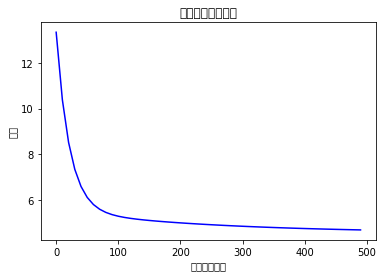

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history[:, 0], history[:, 1], "b")
plt.xlabel("繰り返し回数")
plt.ylabel("損失")
plt.title("学習曲線（損失）")
plt.show()

<br>

次に，学習後のWとBの値から直線の式を求め，散布図に重ね書きしてみましょう．上手くWとBが求められていることが分かると思います．

tensor([-5.,  5.])
tensor([-8.7359,  9.4709])


/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


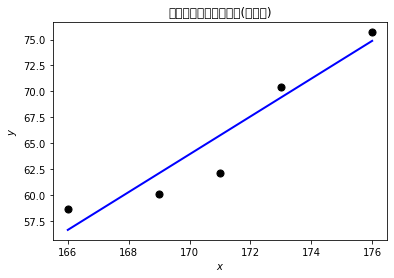

In [ ]:
# --- グラフを見やすくするための前処理 -------
# xの範囲を求める(Xrange)
X_max = X.max()
X_min = X.min()
X_range = np.array((X_min, X_max))
X_range = torch.from_numpy(X_range).float()
print(X_range)

# 対応するyの予測値を求める
Y_range = pred(X_range)
print(Y_range.data)
# --- 前処理ここまで ----------------------


# 学習前に，平均値を引き算しているので，元の身長にもどす
x_range = X_range + x.mean()
yp_range = Y_range + y.mean()

# グラフ描画
plt.scatter(x,  y,  c='k',  s=50)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot(x_range, yp_range.data, lw=2, c='b')
plt.title('身長と体重の相関直線(加工前)')
plt.show()

## 補足：勾配計算
③の勾配計算は，勾配降下法の肝となる部分なので，ここで詳しく説明したいと思います．   
勾配計算には微分の処理が必要になりますが，PyTorchでは
- 自動微分機能

が備わっているため，簡単に勾配計算が可能です．  

ここでは，2次関数 $y=2x^2+2$ を例に計算を行ってみましょう．

In [ ]:
import numpy as np
import torch

x_np = np.arange(-2, 2.1, 0.25) # 適当な範囲のxを用意します

# numpy変数 → Tensor変数に変換します．この時，requires_grad = Trueで勾配計算をするように指定します．
# ちなみに下記のように，dtype=torch.float32と指定する方法でもfloat32に変換することが可能です．
x = torch.tensor(x_np, requires_grad=True, dtype=torch.float32) 

y = 2 * x**2 + 2 # 入力されたxに対して計算を行います．
print(y)

tensor([10.0000,  8.1250,  6.5000,  5.1250,  4.0000,  3.1250,  2.5000,  2.1250,
         2.0000,  2.1250,  2.5000,  3.1250,  4.0000,  5.1250,  6.5000,  8.1250,
        10.0000], grad_fn=<AddBackward0>)


<br>

`出力y`が得られたので，早速勾配を計算したいところですが，
- PyTorchの勾配計算では，計算対象となる関数はスカラーである必要

があります．そこで，
- yの値をsum関数で全て足し合し，その結果をTensor変数zに代入

します．

In [ ]:
z = y.sum()

<br>

ここで，勾配計算する前に，計算グラフを見てみましょう．  
計算グラフとはPyTorchの機能の一つで
- データとそれに対する演算の順番

を可視化できるものです．  

計算グラフは，
- `make_dot`

を使用することで，確認できます．この関数自体は勾配計算には関係ありませんが，処理の流れを確認する時に便利な機能なので知っておいて損はないでしょう．

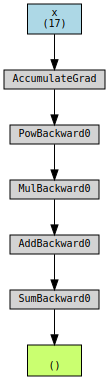

In [ ]:
from torchviz import make_dot
g = make_dot(z, params={'x': x})
display(g)

<br>

勾配計算を行います．  
勾配の計算は，以下のコードのように1行で終了します．

In [ ]:
z.backward() # 勾配計算

<br>

勾配の計算が終わると，勾配値がgrad属性に保存されるので確認してみましょう．

In [ ]:
print(x.grad)

tensor([-8., -7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,
         6.,  7.,  8.])


<br>

結果を可視化してみましょう．  
結果を見てみると，ygradがyの接線になっていますが，勾配は「傾き具合」を示すものなので正しく計算できています． 

---
yの勾配は `x.grad.data` に格納されていることに注意してください

---

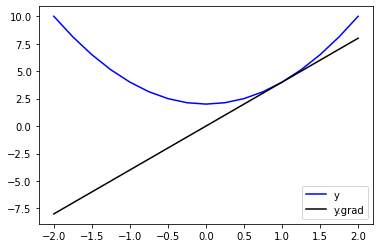

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x.data, y.data, c="b", label="y") # 関数の描画
plt.plot(x.data, x.grad.data, c="k", label="y.grad") # 勾配の描画
plt.legend()
plt.show()

<br>

実際に学習を行う場合は，この勾配を繰り返す必要があるわけですが，
- 繰り返すごとに，勾配値の初期化をする必要がある

ことに注意してください．  

試しに，下記のコードで初期化をせずに勾配を2回行ってみると，勾配の値が2倍されていることが分かると思います．これは
- `x.gard`には最新の値ではなく，今までの勾配計算の結果が加算された値

が入っているためです．

In [ ]:
y = 2 * x**2 + 2
z = y.sum()
z.backward()

print(x.grad)

tensor([-16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,
          8.,  10.,  12.,  14.,  16.])


<br>

上記の結果から，勾配値の初期化を毎回行う必要があることが分かったと思うので，実際に勾配値の初期化を実行してみましょう．

In [ ]:
x.grad.zero_() # 勾配値の初期化
print(x.grad) # 勾配値が初期化されていることを確認できます

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
